In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.listdir("../input/chest-xray-pneumonia/chest_xray")

['chest_xray', '__MACOSX', 'val', 'test', 'train']

In [2]:
len(os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"))

3875

In [3]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"

In [4]:
print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

Train set:
PNEUMONIA=3875
NORMAL=1341


In [5]:
print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

Test set:
PNEUMONIA=390
NORMAL=234


In [6]:
print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

Validation set:
PNEUMONIA=8
NORMAL=8


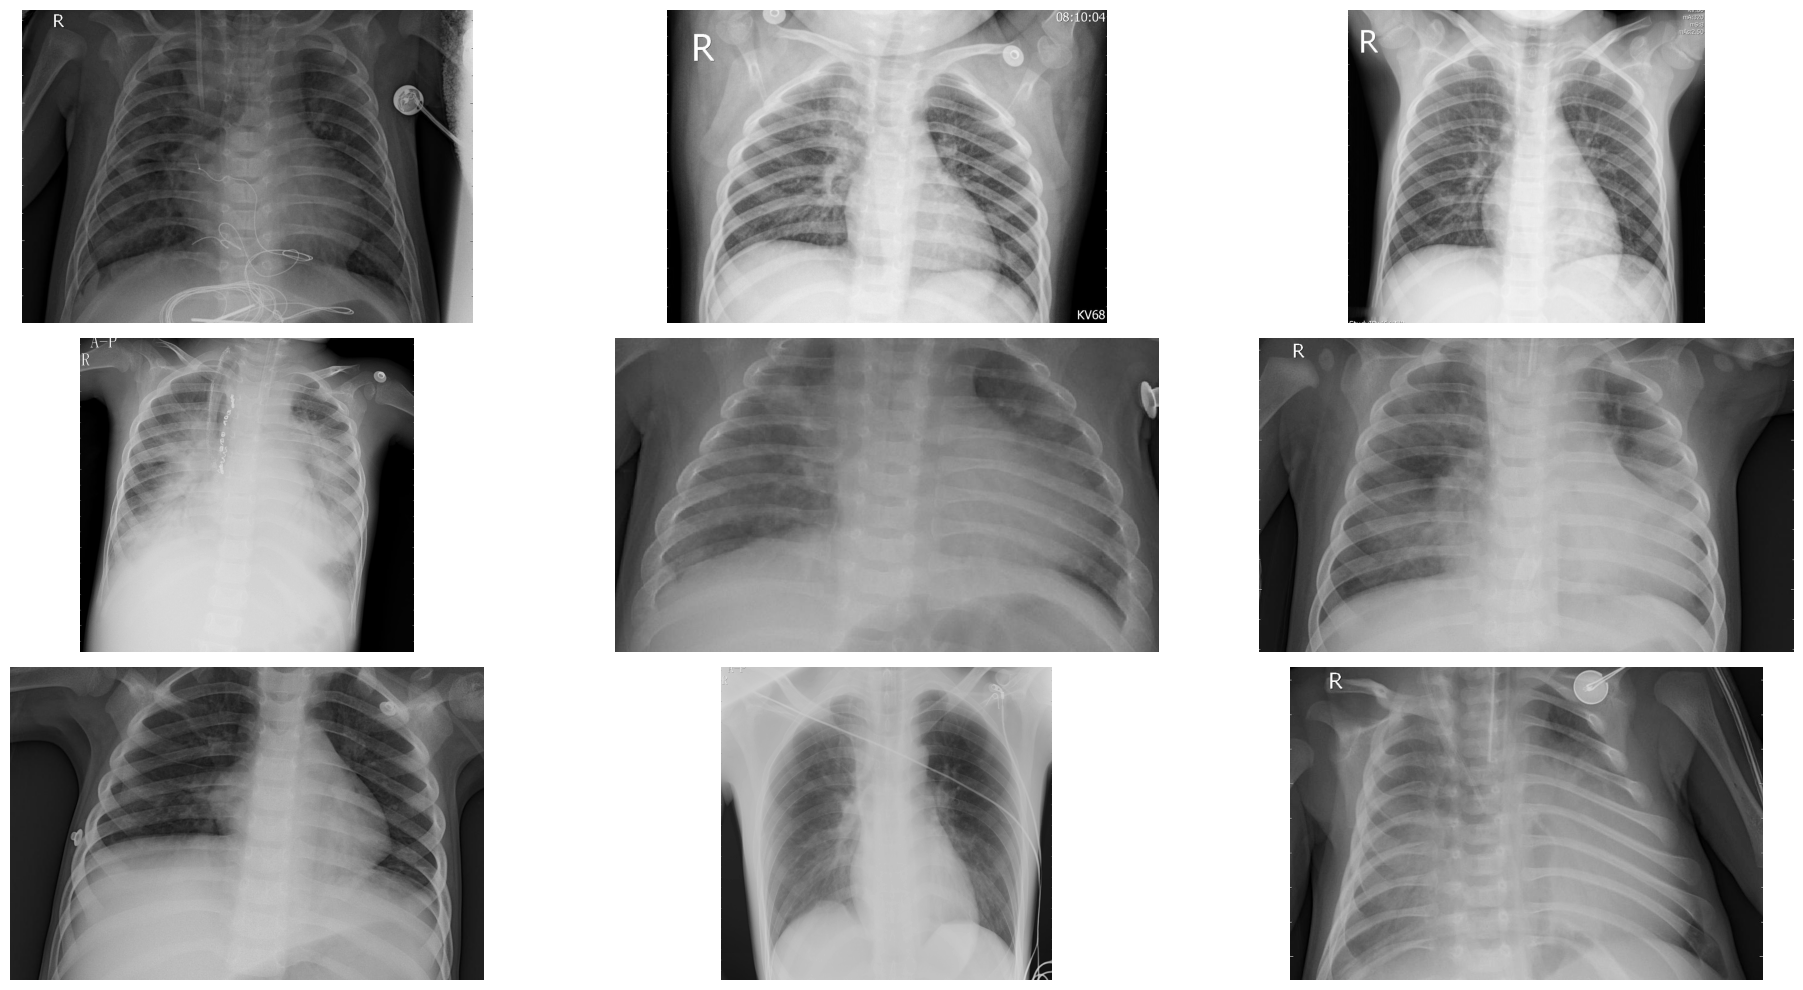

In [7]:
pneumonia = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

# *Getting random image from Pneumonia Dataset*

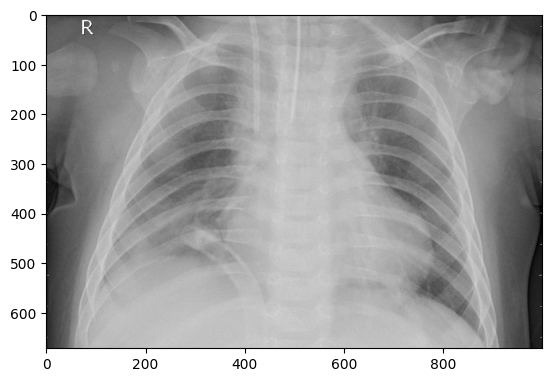

In [8]:
import random as r
index = r.randint(0, 5214)
pneumonia = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"
img = plt.imread(os.path.join(pneumonia_dir, pneumonia[index]))
plt.imshow(img, cmap='gray')

# Using Pytorch

In [9]:
import torch
from torch.utils.data import DataLoader
import os
import torch
from torch import nn, optim
from torch.cuda import amp 
from torchvision import datasets, transforms, models
from torch.cuda.amp import autocast, GradScaler

In [10]:
# Directory paths (adjust these paths based on your setup)
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"

# Check what directories are available (for visualization)
print(os.listdir("../input/chest-xray-pneumonia/chest_xray"))


['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [11]:
# Define transformations for the training set (with augmentations)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((1024, 1024)),  
    
    # Data Augmentation techniques
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(degrees=15),  
    transforms.RandomResizedCrop(size=(1024, 1024), scale=(0.8, 1.0)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    
    # Normalize and convert to tensor
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=(0.5,), std=(0.5,))  
])


In [12]:
# For validation and test sets (no augmentation, only resize and normalize)
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((1024, 1024)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [13]:
# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

In [14]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [15]:
# Print out the number of images in each set
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of training images: 5216
Number of validation images: 16
Number of test images: 624


In [16]:
# Access the class names (folder names)
print(f"Classes: {train_dataset.classes}")

Classes: ['NORMAL', 'PNEUMONIA']


In [17]:
for images, labels in train_loader:
    print(f"Image batch shape: {images.size()}")
    print(f"Labels batch shape: {labels.size()}")
    break  # Just check one batch

Image batch shape: torch.Size([16, 1, 1024, 1024])
Labels batch shape: torch.Size([16])


In [18]:
print(torch.cuda.get_device_name(0))  
print(torch.cuda.is_available())     

Tesla P100-PCIE-16GB
True


In [19]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
class XRayCNN(nn.Module):
    def __init__(self):
        super(XRayCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.batch_norm4 = nn.BatchNorm2d(128)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc1 = nn.Linear(128, 128)  
        self.fc2 = nn.Linear(128, 2)  

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.batch_norm1(self.relu(self.conv1(x))))
        x = self.pool(self.batch_norm2(self.relu(self.conv2(x))))
        x = self.pool(self.batch_norm3(self.relu(self.conv3(x))))
        x = self.pool(self.batch_norm4(self.relu(self.conv4(x))))
        
        x = self.global_pool(x) 
        x = x.view(-1, 128)  

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [21]:
torch.cuda.empty_cache()

In [22]:
# Initialize model, move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the model and move it to the GPU
model = XRayCNN().to(device)

In [23]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use GradScaler for mixed precision
scaler = GradScaler()

/tmp/ipykernel_23/4263489810.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [24]:
num_epochs = 10
accumulation_steps = 3

In [25]:
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        if labels.dim() > 1: 
            labels = torch.argmax(labels, dim=1)

        # Forward pass with mixed precision
        with autocast():  
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backward pass with gradient scaling and accumulation
        scaler.scale(loss).backward()

        # Gradient accumulation
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)  # Updates the weights
            scaler.update()  # Updates the scaler
            optimizer.zero_grad()  # Zero gradients after each step

        running_loss += loss.item()

        # Update correct predictions for training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Clear CUDA cache every few steps (optional)
        if (i + 1) % 10 == 0:
            torch.cuda.empty_cache()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct_train / total_train) * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Training complete.")


/tmp/ipykernel_23/3087966186.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/10], Loss: 0.3905, Accuracy: 81.69%
Epoch [2/10], Loss: 0.2889, Accuracy: 86.96%
Epoch [3/10], Loss: 0.2103, Accuracy: 91.79%
Epoch [4/10], Loss: 0.1725, Accuracy: 93.39%
Epoch [5/10], Loss: 0.1727, Accuracy: 93.33%
Epoch [6/10], Loss: 0.1608, Accuracy: 93.88%
Epoch [7/10], Loss: 0.1461, Accuracy: 94.57%
Epoch [8/10], Loss: 0.1447, Accuracy: 94.57%
Epoch [9/10], Loss: 0.1546, Accuracy: 93.88%
Epoch [10/10], Loss: 0.1345, Accuracy: 95.09%
Training complete.


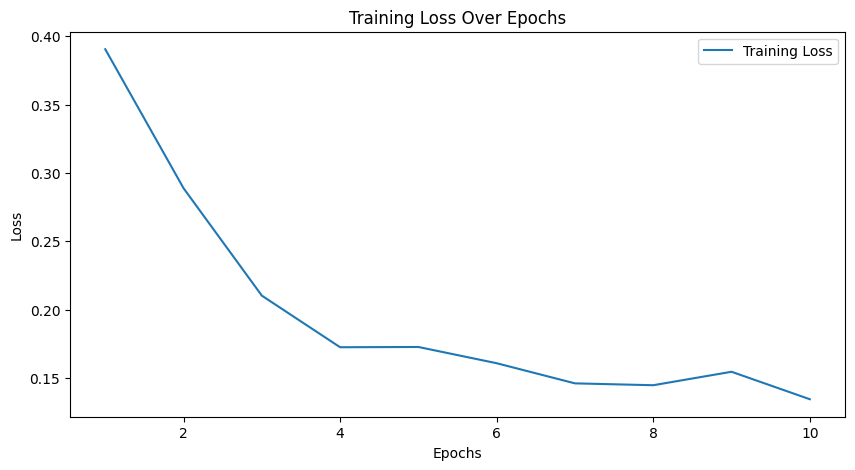

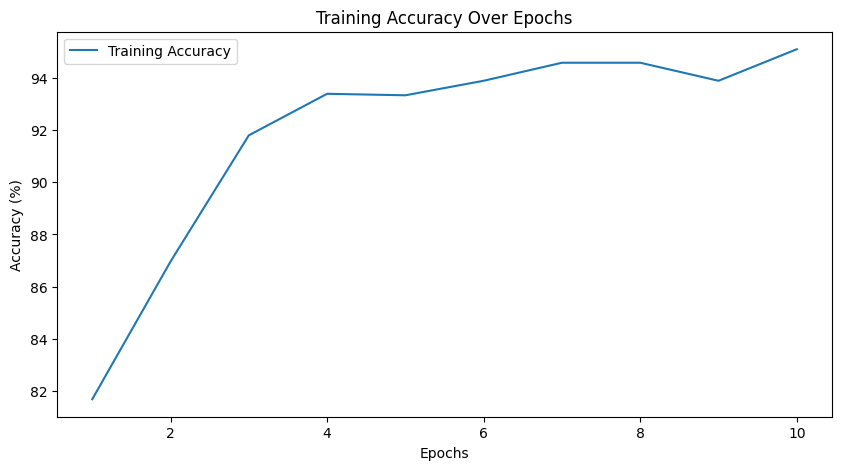

In [26]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


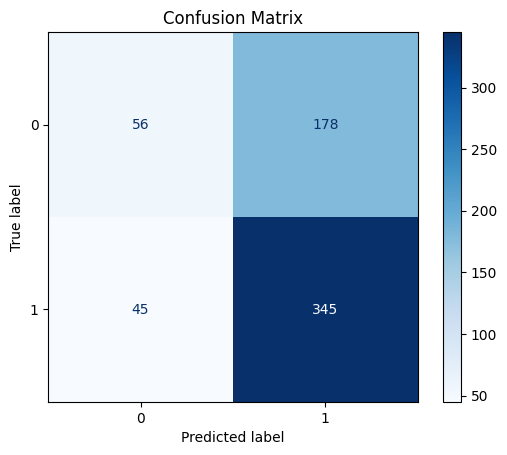

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to store true and predicted labels
all_labels = []
all_predictions = []

# Disable gradient calculation for evaluation
with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted class by taking the class with the highest score
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Move to CPU and store
        all_predictions.extend(predicted.cpu().numpy())  # Move to CPU and store

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


AUC: 0.5717


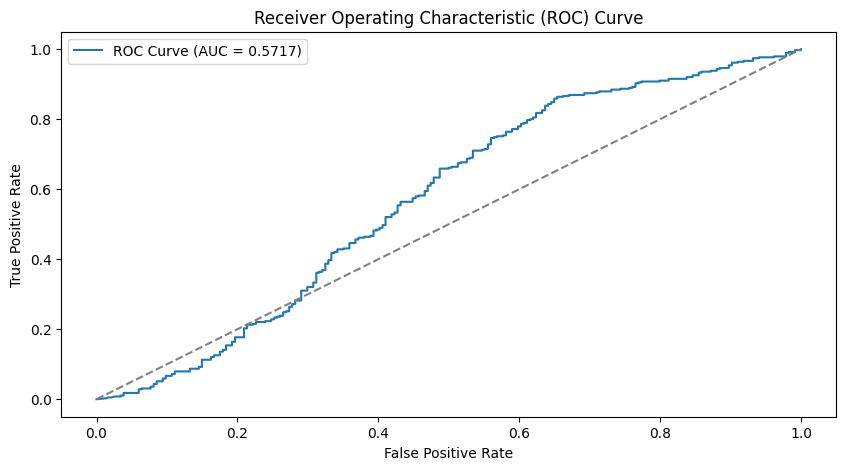

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve
from torch.nn.functional import softmax

# Initialize lists to store true labels and predicted probabilities
all_labels = []
all_probabilities = []

# Disable gradient calculation for evaluation
with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        probabilities = softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class

        all_labels.extend(labels.cpu().numpy())  # Move to CPU and store
        all_probabilities.extend(probabilities.cpu().numpy())  # Move to CPU and store

# Compute AUC
auc = roc_auc_score(all_labels, all_probabilities)
print(f"AUC: {auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [29]:
import torch

model.eval()  # Disable dropout, batch normalization, etc.

# Initialize variables to track the number of correct predictions and total predictions
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted class by taking the class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = (correct / total) * 100
print(f"Accuracy on the test set: {accuracy:.2f}%")


Accuracy on the test set: 89.74%


In [30]:
# Define the path to save the model
model_save_path = "xray_cnn_model.pth"

# Save the model's state_dict (parameters)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to xray_cnn_model.pth


In [31]:
# Load the model's saved state_dict
model = XRayCNN()  # Make sure to instantiate the model class first
model.load_state_dict(torch.load("xray_cnn_model.pth"))
model.to(device)  # Move the model to the correct device (CPU/GPU)

print("Model loaded and ready for inference or further training.")

Model loaded and ready for inference or further training.


/tmp/ipykernel_23/2905116448.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("xray_cnn_model.pth"))
